<a href="https://colab.research.google.com/github/mkm-world/butterfly-classification/blob/main/butterfly_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from tensorflow.keras import backend as K
from tensorflow.keras import models,layers,optimizers, Input
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import utils
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os, shutil
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical

## The data used in this notebook can be gotten [here](https://dphi.tech/challenges/data-sprint-72-butterfly-identification/226/data)

In [2]:
!gdown https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/butterflies.zip

Downloading...
From: https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/butterflies.zip
To: /content/butterflies.zip
100% 240M/240M [00:11<00:00, 20.2MB/s]


In [3]:
# unzipping the file
!unzip -qq /content/butterflies.zip

## Loading in the data 

In [4]:
train=pd.read_csv('/content/Butterfly Identification/Training_set.csv')
test=pd.read_csv('/content/Butterfly Identification/Testing_set.csv')
base_dir='/content/Butterfly Identification/'

## Defining my helper functions

In [5]:
# for reading an image
def read_img(id,ex='train/'):
  img_path=base_dir+ex+str(id)
  img=cv2.imread(img_path,1)
  return img
def load_img(id_list,ex='train/'):
  images=[]
  for id in tqdm(id_list):
    images.append(read_img(id,ex))
  images=np.array(images).reshape(-1,224,224,3)
  return images
def plot_img(image,name, nrows=1, ncols=3):
        """Create subplots of images read"""
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})
        for ax in axes.flat:
            y = np.random.randint(len(image))
            ax.imshow(image[y])
            ax.set_title(name)
        plt.show()
def plot_model_performance(history):
    """Plot model performance"""
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['acc'], label = "Training accuracy")
    plt.plot(history.history["val_acc"], label="Validation accuracy")
    plt.legend()
    plt.title("Training Accracy vs Validation Accuracy")

    plt.subplot(2,2,2)
    plt.plot(history.history["loss"], label = "Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.legend()
    plt.title("Training Loss Vs Validation Loss")

    plt.show()

## Loading the train and test images

In [6]:
train_images=load_img(train.filename)

100%|██████████| 6499/6499 [00:22<00:00, 288.13it/s]


In [7]:
test_images=load_img(test.filename,'test/')

100%|██████████| 2786/2786 [00:03<00:00, 751.98it/s] 


## Little EDA

In [8]:
train.head()# inspecting the data 

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [9]:
train.label.value_counts()

MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: label, Length: 75, dtype: int64

In [10]:
train.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_1.jpg,MOURNING CLOAK
freq,1,131


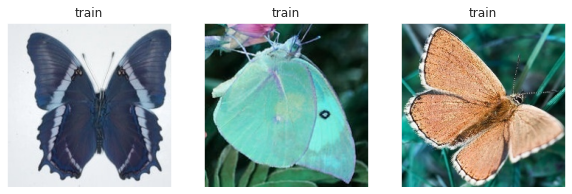

In [11]:
plot_img(train_images[:3],'train')

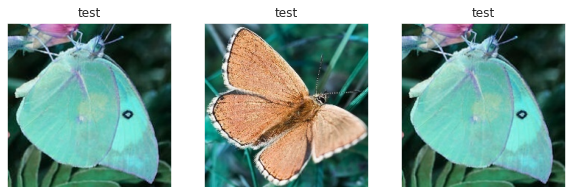

In [12]:
plot_img(train_images[:3],'test')

In [13]:
label=LabelEncoder()
y=label.fit_transform(train.label)
#saving my label_encoder for future deployment purposes
np.save('/content/drive/MyDrive/saved models/classes.npy', label.classes_)

## Prepocessing and Splitting into Training and Validation set 

In [14]:
num_classes=train.label.nunique()
y = utils.to_categorical(y, num_classes)
x_train, x_test, y_train, y_test = train_test_split(train_images,y, random_state=42,stratify=y, test_size=0.2, shuffle=True)

## Modeling
### For the modelling, i used a pretrained efficientNetB1 model, i started with the imagenet pretained weights and finetuned the last 5 layers, i also removed the top and added two dense layers as my classifier. 

In [15]:

from tensorflow.keras.applications import efficientnet
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
base_model=efficientnet.EfficientNetB1(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
#  add a fully-connected layer
x=Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x=Dropout(0.3)(x)
# and a logistic layer 
predictions = Dense(num_classes, activation='softmax')(x)
# add early stopping to prevent overfitting
callback = EarlyStopping(monitor='val_loss', patience=3)
model = Model(inputs=base_model.input, outputs=predictions)
#i.e. freeze all but last ten convolutional efficientnet layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# compiling the model 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

27033600/27018416 [==============================] - 0s 0us/step


## Fitting the model 

In [16]:
history=model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size=64, epochs=10,callbacks=[callback])

Epoch 1/10
82/82 [==============================] - 40s 247ms/step - loss: 2.0829 - acc: 0.5109 - val_loss: 0.6003 - val_acc: 0.8185
Epoch 2/10
82/82 [==============================] - 16s 197ms/step - loss: 0.5890 - acc: 0.8325 - val_loss: 0.4237 - val_acc: 0.8754
Epoch 3/10
82/82 [==============================] - 18s 226ms/step - loss: 0.3599 - acc: 0.8925 - val_loss: 0.4356 - val_acc: 0.8854
Epoch 4/10
82/82 [==============================] - 16s 195ms/step - loss: 0.2449 - acc: 0.9306 - val_loss: 0.3761 - val_acc: 0.9031
Epoch 5/10
82/82 [==============================] - 16s 198ms/step - loss: 0.1898 - acc: 0.9419 - val_loss: 0.3576 - val_acc: 0.9069
Epoch 6/10
82/82 [==============================] - 16s 199ms/step - loss: 0.1456 - acc: 0.9569 - val_loss: 0.3952 - val_acc: 0.9015
Epoch 7/10
82/82 [==============================] - 16s 197ms/step - loss: 0.1043 - acc: 0.9719 - val_loss: 0.3624 - val_acc: 0.9200
Epoch 8/10
82/82 [==============================] - 16s 197ms/step - 

## Model perfomance

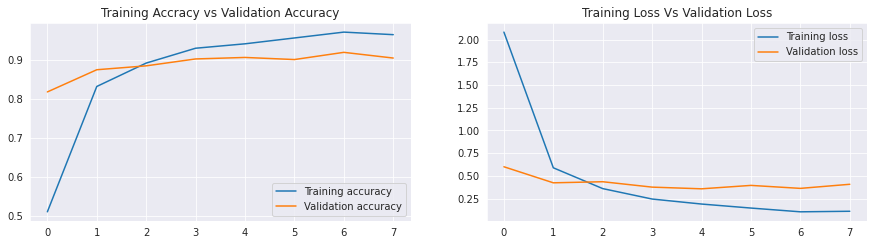

In [17]:
plot_model_performance(history)

In [19]:
model.save('butterfly_model.h5')
!mv '/content/butterfly_model.h5' '/content/drive/MyDrive/saved models/'

## Predicting on the test dataset

In [20]:
test_preds=model.predict(test_images)
test_preds=label.inverse_transform(np.argmax(test_preds,axis=1))
test['label']=test_preds
test.to_csv('testing_drop_effnet1_3.csv',index=False)